In [1]:
import numpy as np
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
import csv
import pandas as pd
from sklearn.model_selection import GridSearchCV
from tensorflow import keras
from sklearn.model_selection import StratifiedShuffleSplit
from tensorflow.keras import layers
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Dropout
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import BaggingClassifier
from keras.models import load_model
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier

plt.style.use('ggplot')

Using TensorFlow backend.


In [11]:
derivatives_data = pd.read_csv('music/tagged_feature_sets/msd-jmirderivatives_dev/msd-jmirderivatives_dev.csv', delimiter = ',', header=None)
label_derivatives = derivatives_data[98]
derivatives = derivatives_data.values[:, 2:97]

In [12]:
lpc_data = pd.read_csv('music/tagged_feature_sets/msd-jmirlpc_dev/msd-jmirlpc_dev.csv', delimiter = ',', header=None)
label_lpc = lpc_data[22]
lpc = lpc_data.values[:, 2:21]

In [13]:
mfcc_data = pd.read_csv('music/tagged_feature_sets/msd-jmirmfccs_dev/msd-jmirmfccs_dev.csv', delimiter = ',', header=None)
label_mfcc = mfcc_data[28]
mfcc = mfcc_data.values[:, 2:27]

In [14]:
moments_data = pd.read_csv('music/tagged_feature_sets/msd-jmirmoments_dev/msd-jmirmoments_dev.csv', delimiter = ',', header=None)
label_moments = moments_data[12]
moments = moments_data.values[:, 2:11]

In [15]:
spectral_data = pd.read_csv('music/tagged_feature_sets/msd-jmirspectral_dev/msd-jmirspectral_dev.csv', delimiter = ',', header=None)
label_spectral = spectral_data[18]
spectral = spectral_data.values[:, 2:17]

In [16]:
marsyas_data = pd.read_csv('music/tagged_feature_sets/msd-marsyas_dev_new/msd-marsyas_dev_new.csv', delimiter = ',', header=None)
label_marsyas = marsyas_data[126]
marsyas = marsyas_data.values[:, 2:125]

In [17]:
mvd_data = pd.read_csv('music/tagged_feature_sets/msd-mvd_dev/msd-mvd_dev.csv', delimiter = ',', header=None)
label_mvd = mvd_data[422]
mvd = mvd_data.values[:, 2:421]

In [18]:
rh_data = pd.read_csv('music/tagged_feature_sets/msd-rh_dev_new/msd-rh_dev_new.csv', delimiter = ',', header=None)
label_rh = rh_data[62]
rh = rh_data.values[:, 2:61]

In [19]:
ssd_data = pd.read_csv('music/tagged_feature_sets/msd-ssd_dev/msd-ssd_dev.csv', delimiter = ',', header=None)
label_ssd = ssd_data[170]
ssd = ssd_data.values[:, 2:169]

In [20]:
trh_data = pd.read_csv('music/tagged_feature_sets/msd-trh_dev/msd-trh_dev.csv', delimiter = ',', header=None)
label_trh = trh_data[422]
trh = trh_data.values[:, 2:421]

## Exploration des données
---

In [88]:
pd.DataFrame(label_derivatives.value_counts())

,98
POP_INDIE,11858
ROCK_COLLEGE,10856
ROCK_CONTEMPORARY,10829
HIP_HOP_RAP,10581
DANCE,9885
METAL_ALTERNATIVE,9195
POP_CONTEMPORARY,8959
ROCK_HARD,8720
ROCK_ALTERNATIVE,8333
EXPERIMENTAL,7932


On remarque que les données ne sont pas en proportions égales. La classe majoritaire est le `POP_INDIE` avec 11858 musiques correspondants à cette classe. Il faudrait donc faire en sorte d'avoir une distribution environnante celle-ci pour nos ensembles de tests etc.

In [9]:
all_data = ['derivatives', 'lpc', 'mfcc', 'moments', 'spectral', 'marsyas', 'mvd', 'rh', 'ssd', 'trh']
all_labels = ['label_derivatives', 'label_lpc', 'label_mfcc', 'label_moments', 'label_spectral', 'label_marsyas', 'label_mvd', 'label_rh', 'label_ssd', 'label_trh']

### PCA

In [89]:
# number of classes
n_class = len(set(label_derivatives))
print("Nombre de classes : {}".format(n_class))

# vector with distinct labels
label_list = np.unique(label_derivatives)

print(label_list)

# vector of all labels
labels = np.array(label_derivatives)

Nombre de classes : 25
['BIG_BAND' 'BLUES_CONTEMPORARY' 'COUNTRY_TRADITIONAL' 'DANCE'
 'ELECTRONICA' 'EXPERIMENTAL' 'FOLK_INTERNATIONAL' 'GOSPEL' 'GRUNGE_EMO'
 'HIP_HOP_RAP' 'JAZZ_CLASSIC' 'METAL_ALTERNATIVE' 'METAL_DEATH'
 'METAL_HEAVY' 'POP_CONTEMPORARY' 'POP_INDIE' 'POP_LATIN' 'PUNK' 'REGGAE'
 'RNB_SOUL' 'ROCK_ALTERNATIVE' 'ROCK_COLLEGE' 'ROCK_CONTEMPORARY'
 'ROCK_HARD' 'ROCK_NEO_PSYCHEDELIA']


In [56]:
def plot_pca(data, labels):
    # vector of all labels
    labels = np.array(labels)
    
    # pca with 2 components
    pca = PCA(n_components=2)
    principalComponents = pca.fit_transform(data)
    principalDf = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2'])

    
    # plot pca
    fig = plt.figure(figsize = (8,8))
    ax = fig.add_subplot(1,1,1) 
    ax.set_xlabel('Principal Component 1', fontsize = 15)
    ax.set_ylabel('Principal Component 2', fontsize = 15)
    ax.set_title('2 Component PCA', fontsize = 20)

    finalDf = pd.concat([principalDf, pd.DataFrame(labels, columns=['target'])], axis = 1)

    targets = labels
    colors = np.arange(n_class)
    for target, color in zip(targets,colors):
        indicesToKeep = finalDf['target'] == target
        ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
                   , finalDf.loc[indicesToKeep, 'principal component 2']
                   , s = 50)
    ax.legend(targets)
    ax.grid()

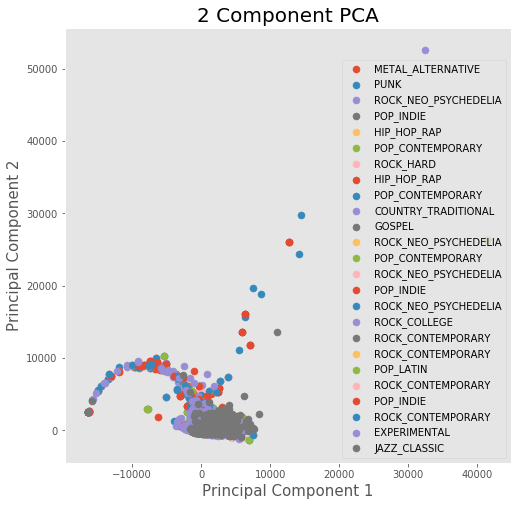

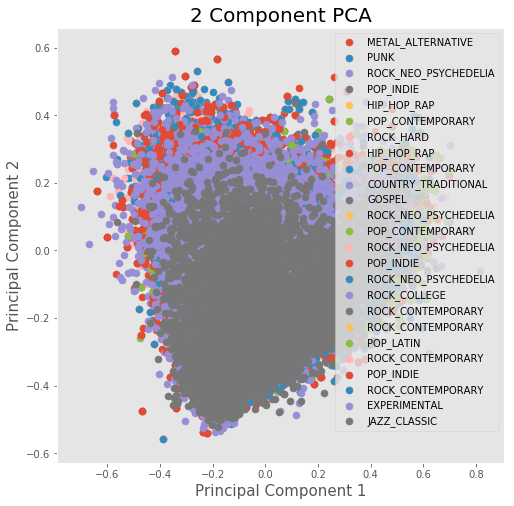

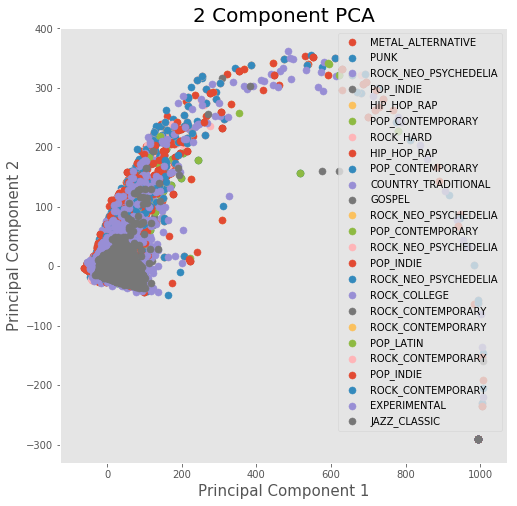

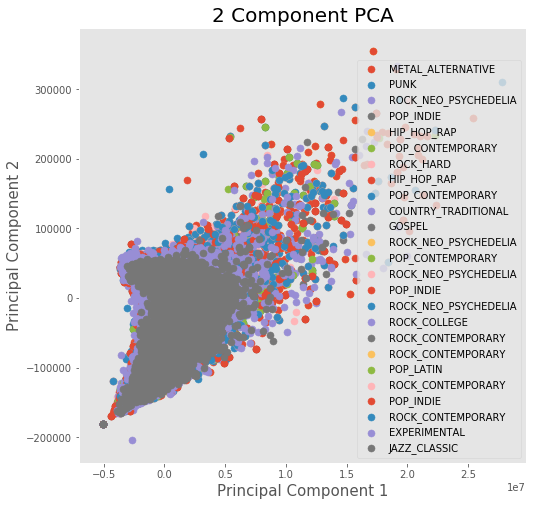

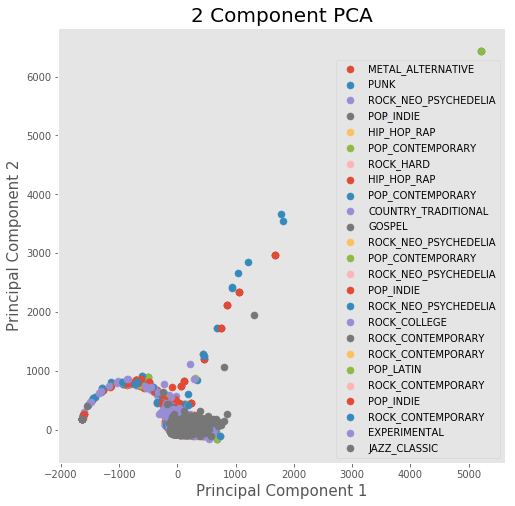

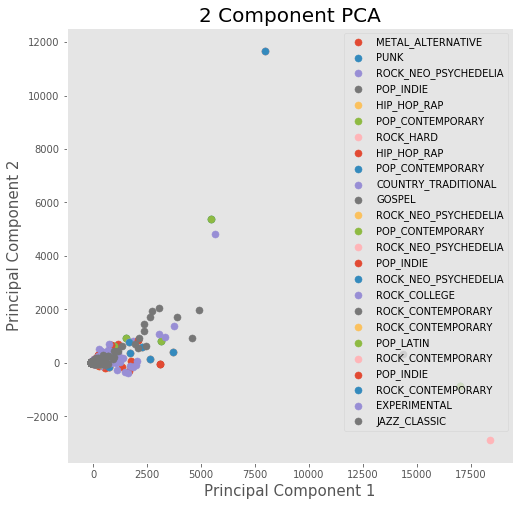

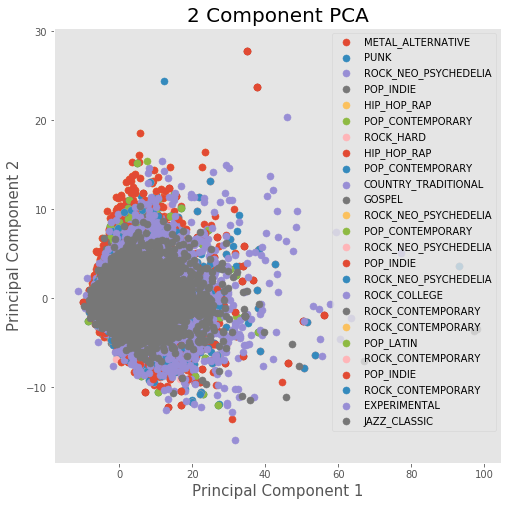

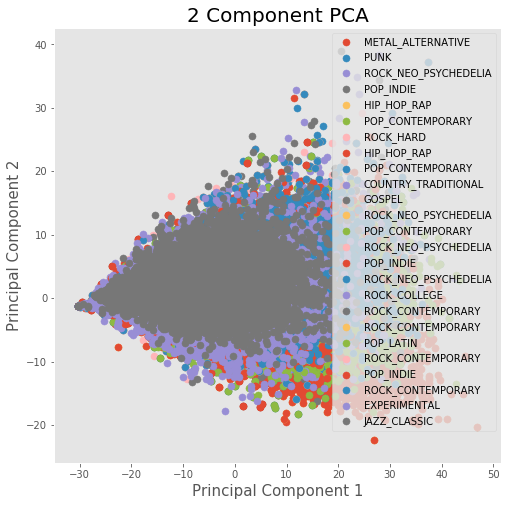

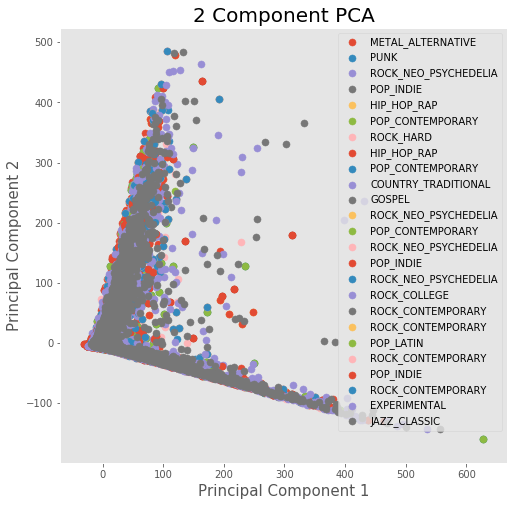

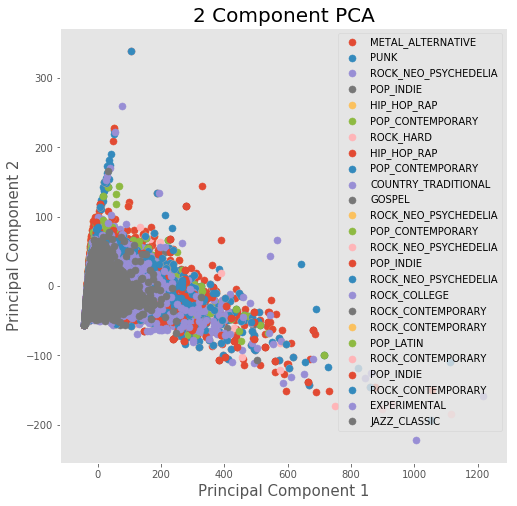

In [93]:
plot_pca(derivatives, label_derivatives)
plot_pca(lpc, label_lpc)
plot_pca(mfcc, label_mfcc)
plot_pca(moments, label_moments)
plot_pca(spectral, label_spectral)
plot_pca(marsyas, label_marsyas)
plot_pca(mvd, label_mvd)
plot_pca(rh, label_rh)
plot_pca(ssd, label_ssd)
plot_pca(trh, label_trh)

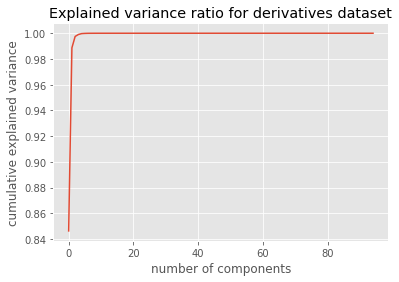

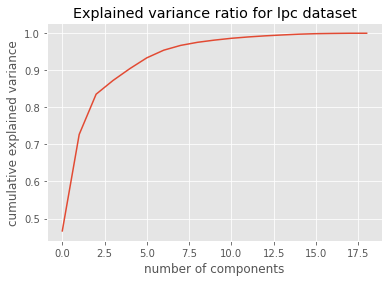

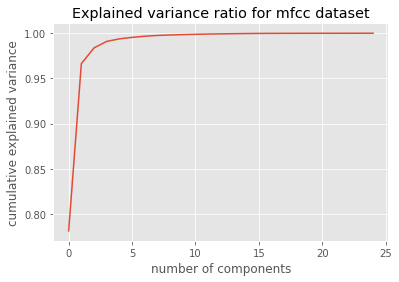

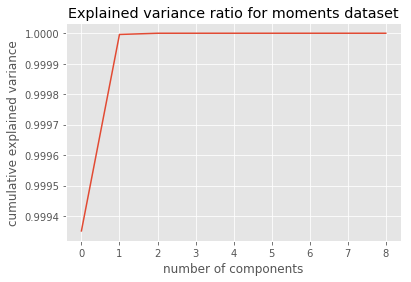

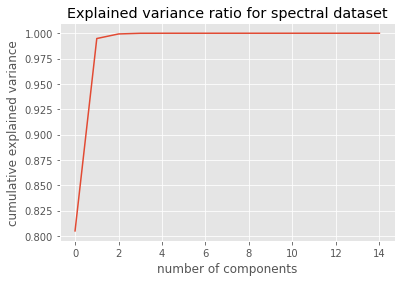

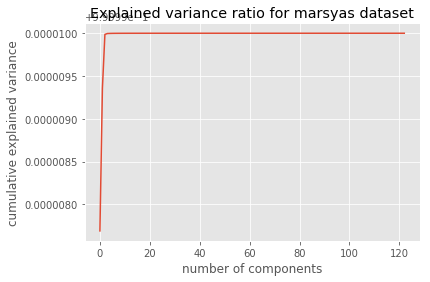

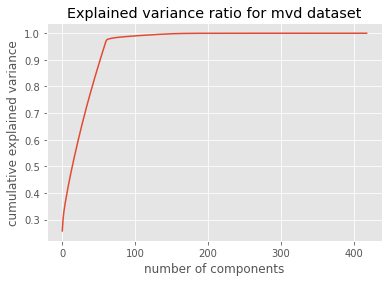

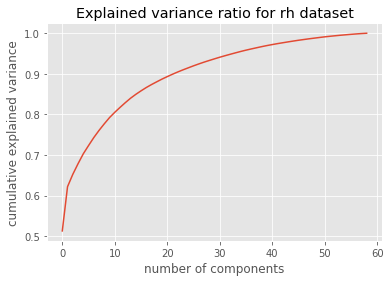

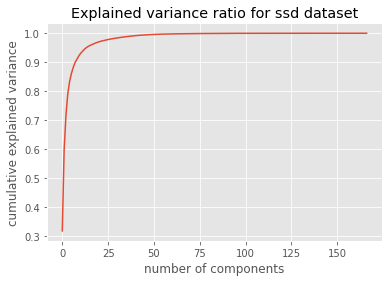

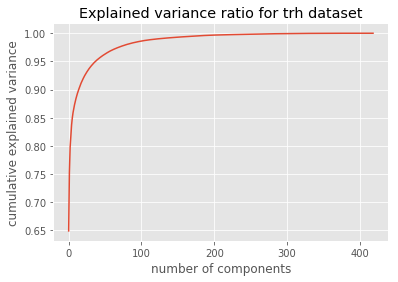

In [92]:
def get_ratio_pca(data):
    pca = PCA().fit(eval(data))
    plt.plot(np.cumsum(pca.explained_variance_ratio_))
    plt.xlabel('number of components')
    plt.ylabel('cumulative explained variance')
    plt.title('Explained variance ratio for {} dataset'.format(data))
    plt.show()

for data in all_data:
    get_ratio_pca(data)

On remarque que la plupart de nos ensembles de données peuvent être décrites en un nombre assez petit de composantes principales. En effet, il semble que les données soient assez redondantes, cela nous permet donc d'accélérer l'application de nos algorithmes, de faciliter la visualisation de la description de nos données.

## LDA
---

In [21]:
"""
lda = LinearDiscriminantAnalysis()
X_train, X_test, y_train, y_test = train_test_split(derivatives, label_derivatives, test_size=0.33, random_state=42)
lda.fit(X_train, y_train)
print("score lda derivatives : {}".format(lda.score(X_test, y_test)))

lda = LinearDiscriminantAnalysis()
X_train, X_test, y_train, y_test = train_test_split(mfcc, label_mfcc, test_size=0.33, random_state=42)
lda.fit(X_train, y_train)
print("score lda mfcc : {}".format(lda.score(X_test, y_test)))
"""

def lda_all(features, labels):
    for data, classes in zip(features, labels):
        lda = LinearDiscriminantAnalysis()
        scores = cross_val_score(lda, eval(data), eval(classes), cv=5, scoring='f1_weighted')
        print("f1 score {} : {}".format(data, scores.mean()))
        """
        X_train, X_test, y_train, y_test = train_test_split(eval(data), eval(classes), test_size=0.33, random_state=42)
        lda.fit(X_train, y_train)
        print("score lda {} : {}".format(data, lda.score(X_test, y_test)))
        y_pred = lda.predict(X_test)
        print("f1 score {} : {}".format(data, f1_score(y_test, y_pred, average='weighted')))
        """
        
lda_all(all_data, all_labels)

f1 score derivatives : 0.2220137722809973


/Users/raen/anaconda3/envs/gti770_env/lib/python3.5/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/Users/raen/anaconda3/envs/gti770_env/lib/python3.5/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/raen/anaconda3/envs/gti770_env/lib/python3.5/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/Users/raen/anaconda3/envs/gti770_env/lib/python3.5/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/raen/anaconda3/envs/gti770_env/lib/python3.5/site-packages/sklearn/discriminant_analysis.py:388: UserWarn

f1 score lpc : 0.14339170985316385
f1 score mfcc : 0.17395521319375395


/Users/raen/anaconda3/envs/gti770_env/lib/python3.5/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/raen/anaconda3/envs/gti770_env/lib/python3.5/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/raen/anaconda3/envs/gti770_env/lib/python3.5/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/raen/anaconda3/envs/gti770_env/lib/python3.5/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 

f1 score moments : 0.1272308493631881
f1 score spectral : 0.1618738845629455
f1 score marsyas : 0.24617277130131826
f1 score mvd : 0.1868039539482697


/Users/raen/anaconda3/envs/gti770_env/lib/python3.5/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/raen/anaconda3/envs/gti770_env/lib/python3.5/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/raen/anaconda3/envs/gti770_env/lib/python3.5/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/raen/anaconda3/envs/gti770_env/lib/python3.5/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 

f1 score rh : 0.13237715964581084
f1 score ssd : 0.24953652915205282
f1 score trh : 0.15308925070619628


## Bagging
---
Généralement, tous les apprenants sont d’un même
type, mais entrainés avec des paramètres
différents.

In [47]:
# Create classifiers
mlp = load_model('wideMPLmarsyas.hdf5')
knn = KNeighborsClassifier()
lda = LinearDiscriminantAnalysis()

"""
def bagging_classification(data, labels):
    X_train, X_test, y_train, y_test = train_test_split(data, labels)

    grid = ParameterGrid({"max_samples": [0.5, 1.0],
                          "max_features": [1, 2, 4],
                          "bootstrap": [True, False],
                          "bootstrap_features": [True, False]})


    for base_estimator in [None,
                           knn,
                           lda,
                           mlp]:
       
        BaggingClassifier(base_estimator=base_estimator).fit(X_train, y_train).predict(X_test)
    

        for params in grid:
            BaggingClassifier(base_estimator=base_estimator,
                              **params).fit(X_train, y_train).predict(X_test) 
    """

In [6]:
def bagging_class(X, y, n_neigh):
    # Scale the data
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    
    # Create classifiers
    mlp = MLPClassifier(hidden_layer_sizes=(200, 75), activation='relu', 
                        solver='adam', alpha=0, batch_size=500, 
                        learning_rate='adaptive', learning_rate_init=5e-4, max_iter=200, 
                        shuffle=True, verbose=False)
    knn = KNeighborsClassifier()
    lda = LinearDiscriminantAnalysis()
    
    clf_array = [mlp, knn, lda]
    
    # Bagging
    for clf in clf_array:
        bagging_clf = BaggingClassifier(clf)
        bagging_scores = cross_val_score(bagging_clf, X, y, cv=5)

        print("Mean of: {1:.3f}, std: (+/-) {2:.3f} [Bagging {0}]\n".format(clf.__class__.__name__, 
                            bagging_scores.mean(), bagging_scores.std()))


In [7]:
# PCA before bagging
pca = PCA(n_components = 1)
pca_marsyas = pca.fit_transform(marsyas)

bagging_class(pca_marsyas, label_marsyas, 5)

Mean of: 0.066, std: (+/-) 0.000 [Bagging MLPClassifier]

Mean of: 0.058, std: (+/-) 0.001 [Bagging KNeighborsClassifier]

Mean of: 0.066, std: (+/-) 0.000 [Bagging LinearDiscriminantAnalysis]



## KNN
---

In [3]:
def knn(data, labels, n_components, n_neighbors=5):
    pca = PCA(n_components)
    principalComponents = pca.fit_transform(data)
    
    X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.33, random_state=42)
    
    knn = KNeighborsClassifier(n_neighbors=n_neighbors, weights='distance') 
    knn.fit(X_train, y_train) 
    y_pred = knn.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print("Accuracy : {}".format(accuracy))

    f1 = f1_score(y_test, y_pred, average='weighted')
    print("F1 Score : {}".format(f1))

In [ ]:
knn(derivatives, label_derivatives, 1)
knn(lpc, label_lpc, 3)
knn(mfcc, label_mfcc, 1)
knn(moments, label_moments, 1)
knn(spectral, label_spectral, 1)
knn(marsyas, label_marsyas, 1)

In [2]:
#knn(mvd, label_mvd, 30)
#knn(rh, label_rh, 20)
knn(ssd, label_ssd, 10)
#knn(trh, label_trh, 20)

NameError: name 'knn' is not defined

In [ ]:
data = marsyas
labels = label_marsyas
pca = PCA(n_components=1)
principalComponents = pca.fit_transform(data)
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.33, random_state=42)

parameters = {'n_neighbors:':[1, 3, 5, 10]}
knnclf = KNeighborsClassifier()
clf = GridSearchCV(knnclf, parameters, cv=5)
clf.fit(X_train, y_train)

## Boosting
---
### GradientBoostingClassifier

In [19]:
data = mfcc
labels = label_mfcc
pca = PCA(n_components=1)
principalComponents = pca.fit_transform(data)
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.33, random_state=42)

boost = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,
                                 max_depth=1, random_state=0).fit(X_train, y_train)
print(boost.score(X_test, y_test))
print(boost.score(X_test, y_test).mean())

0.04014918824045634
0.04014918824045634


### Adaboost
AdaBoostClassifier, BernoulliNB, DecisionTreeClassifier, ExtraTreeClassifier, ExtraTreesClassifier, MultinomialNB, NuSVC, Perceptron, RandomForestClassifier, RidgeClassifierCV, SGDClassifier, SVC.

In [18]:
abc = AdaBoostClassifier(base_estimator=None, n_estimators=100)
abc_scores = cross_val_score(abc, pca_mfcc, label_mfcc, cv=5)
print("Score : {}".format(abc_scores.mean()))

Score : 0.09827054552360666
